# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [29]:
# Load the libraries as required.

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np
import os
import pickle
import shap

In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
X = fires_dt.drop(columns=['area'])
Y = fires_dt['area']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [4]:
num_col = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

cat_col = ['month', 'day']

rob_sc = StandardScaler()

enc = OneHotEncoder(handle_unknown='ignore')

pipe_num1 = Pipeline([
    ('StandardScaler', rob_sc)
])

pipe_cat = Pipeline([
    ('OneHotEncoder', enc)
])

preproc1 = ColumnTransformer(
    transformers=[
        ('num_transforms', pipe_num1, num_col),
        ('cat_transforms', pipe_cat, cat_col)
    ]
)

In [5]:
preproc1

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('StandardScaler',
                                                  StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('OneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
pwr_trans = PowerTransformer()

pipe_num2 = Pipeline([
    ('StandardScaler', rob_sc),
    ('PowerTransformer', pwr_trans)
])

preproc2 = ColumnTransformer(
    transformers=[
        ('num_transforms', pipe_num2, num_col),
        ('cat_transforms', pipe_cat, cat_col)
    ]
)

In [7]:
preproc2

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('StandardScaler',
                                                  StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('OneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [8]:
# Pipeline A = preproc1 + baseline

base_regressor = Ridge()
adv_regressor = RandomForestRegressor()

pipe1_base = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', base_regressor)
])


In [9]:
# Pipeline B = preproc2 + baseline

pipe2_base = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', base_regressor)
])

In [10]:
# Pipeline C = preproc1 + advanced model

pipe1_adv = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', adv_regressor)
])


In [11]:
# Pipeline D = preproc2 + advanced model

pipe2_adv = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', adv_regressor)
])    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [12]:
param_grid_base = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
}

param_grid_adv = {
    'regressor__n_estimators': [50, 100, 150, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10, 15]
}

def tune_and_evaluate(pipeline, param_grid, X, Y):
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, Y)
    best_model = grid_search.best_estimator_
    cv_scores = cross_val_score(best_model, X, Y, cv=5, scoring='neg_mean_squared_error')
    
    # Convert scores to positive and calculate RMSE
    rmse_scores = np.sqrt(-cv_scores)
    print("Cross-validation RMSE scores:", rmse_scores)
    
    return best_model, np.mean(rmse_scores), np.std(rmse_scores)

In [13]:
exp_pipe1_base = tune_and_evaluate(pipe1_base, param_grid_base, X_train, Y_train)

exp_pipe2_base = tune_and_evaluate(pipe2_base, param_grid_base, X_train, Y_train)

exp_pipe1_adv = tune_and_evaluate(pipe1_adv, param_grid_adv, X_train, Y_train)

exp_pipe2_adv = tune_and_evaluate(pipe2_adv, param_grid_adv, X_train, Y_train)

Cross-validation RMSE scores: [40.73174954 18.64922127 33.07464279 85.1100378  25.80533281]
Cross-validation RMSE scores: [40.43061209 18.86599104 28.35619962 85.01209196 25.41001625]
Cross-validation RMSE scores: [49.71436545 26.97434222 27.71586062 85.99593998 26.51909488]
Cross-validation RMSE scores: [52.70634968 26.37442672 28.24867373 85.87246603 26.3598275 ]


In [14]:
results = {
    "Pipeline 1 Base": exp_pipe1_base,
    "Pipeline 2 Base": exp_pipe2_base,
    "Pipeline 1 Advanced": exp_pipe1_adv,
    "Pipeline 2 Advanced": exp_pipe2_adv
}

# Print the results
for name, result in results.items():
    best_model, mean_rmse, std_rmse = result
    print(f"{name} Results:")
    print(f"Best Model: {best_model}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    print(f"Std RMSE: {std_rmse:.4f}")
    print("-" * 40)

Pipeline 1 Base Results:
Best Model: Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', Ridge(alpha=10.0))])
Mean RMSE: 40.6742
Std RMSE: 23.4029
-------------------------------

In [15]:
# Identify the best model based on Mean RMSE
best_model_name = min(results, key=lambda k: results[k][1])
best_model_pipeline, best_mean_rmse, best_std_rmse = results[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Mean RMSE: {best_mean_rmse:.4f}")
print(f"Std RMSE: {best_std_rmse:.4f}")

Best Model: Pipeline 2 Base
Mean RMSE: 39.6150
Std RMSE: 23.7513


# Evaluate

+ Which model has the best performance?

Pipeline 2 with Base Regressor (Ridge) has the lowest Mean RMSE of 39.6150, indicating it has the best performance among the four pipelines evaluated.

# Export

+ Save the best performing model to a pickle file.

In [23]:
best_model_pipeline = exp_pipe2_base[0]

best_model_pipeline.fit(X_train, Y_train)

model_filename = 'best_performing_model.pkl'

model_filepath = os.path.join('../../05_src/data/fires', model_filename)

with open(model_filepath, 'wb') as file:
    pickle.dump(best_model_pipeline, file)

In [24]:
#checking if the file was created
if os.path.exists(model_filepath):
    print(f"The file was successfully created at: {os.path.abspath(model_filepath)}")

The file was successfully created at: /Users/olha/Data_Science/class-training/scaling_to_production/05_src/data/fires/best_performing_model.pkl


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [30]:
data_transform = best_model_pipeline.named_steps['preprocessing'].transform(X_test)

explainer = shap.explainers.Linear(
    best_model_pipeline.named_steps['regressor'], 
    data_transform,
    feature_names = best_model_pipeline.named_steps['preprocessing'].get_feature_names_out())

shap_values = explainer(data_transform)

shap_values

.values =
array([[ 2.91823579, -0.12936721, -0.75023806, ..., -0.63627942,
         0.08393233, -0.05384539],
       [ 5.01050351, -0.12936721,  1.29336185, ..., -0.63627942,
        -0.67908888, -0.05384539],
       [ 7.07180782, -0.26897645,  0.05252404, ..., -0.63627942,
         0.08393233, -0.05384539],
       ...,
       [ 0.7855865 ,  0.02415197, -0.16182382, ..., -0.63627942,
         0.08393233, -0.05384539],
       [-5.9205591 ,  0.02415197, -0.91982181, ..., -0.63627942,
         0.08393233, -0.05384539],
       [ 2.91823579,  0.19521018,  0.21564826, ...,  4.66604911,
         0.08393233, -0.05384539]])

.base_values =
array([9.85360964, 9.85360964, 9.85360964, 9.85360964, 9.85360964,
       9.85360964, 9.85360964, 9.85360964, 9.85360964, 9.85360964,
       9.85360964, 9.85360964, 9.85360964, 9.85360964, 9.85360964,
       9.85360964, 9.85360964, 9.85360964, 9.85360964, 9.85360964,
       9.85360964, 9.85360964, 9.85360964, 9.85360964, 9.85360964,
       9.85360964, 9.85360

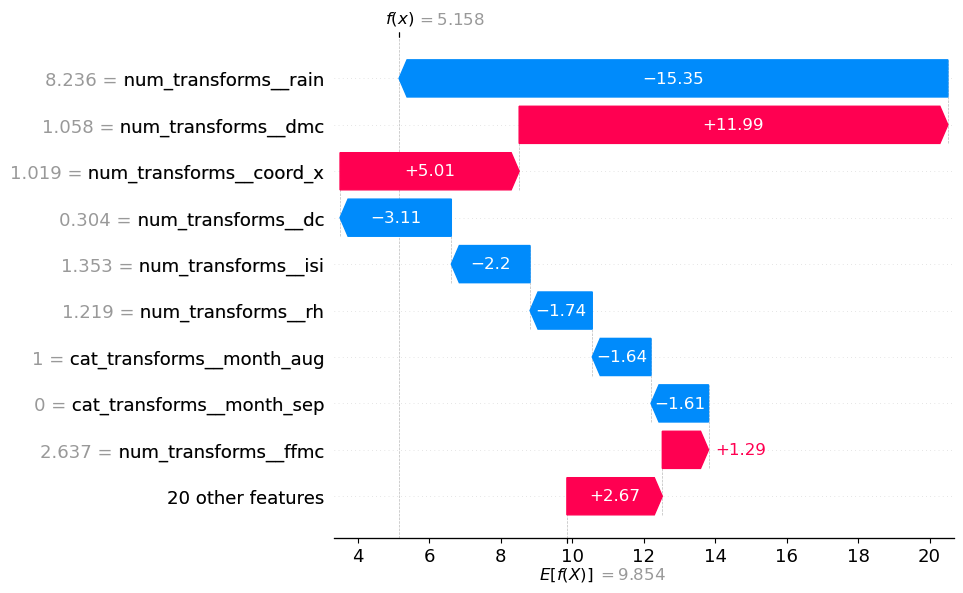

In [28]:
shap.plots.waterfall(shap_values[1])

In [40]:
# Define which features are the most important, the least important and not important at all

shap_values_array = shap_values.values

preprocessing = best_model_pipeline.named_steps['preprocessing']
numeric_feature_names = preprocessing.transformers_[0][2]
categorical_feature_names = preprocessing.transformers_[1][1]['OneHotEncoder'].get_feature_names_out()
feature_names = np.concatenate((numeric_feature_names, categorical_feature_names))

# Aggregate SHAP values across instances to get feature importance
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

# Identify most important features
important_features_indices = np.argsort(mean_abs_shap)[::-1]
important_features_names = feature_names[important_features_indices]

# Identify least important features
least_important_features_indices = np.argsort(mean_abs_shap)
least_important_features_names = feature_names[least_important_features_indices]

# Print feature importance ranking with names
print("Most important features:")
for name, value in zip(important_features_names, mean_abs_shap[important_features_indices]):
    print(f"Feature {name}: Mean SHAP value = {value}")

print("\nLeast important features:")
for name, value in zip(least_important_features_names, mean_abs_shap[least_important_features_indices]):
    print(f"Feature {name}: Mean SHAP value = {value}")

# Example of removing features based on a threshold (e.g., mean SHAP value)
threshold = 0.1  # Example threshold
features_to_remove = [i for i, value in enumerate(mean_abs_shap) if value < threshold]

print("\nFeatures to remove:")
for feature_index in features_to_remove:
    print(f"Feature {feature_names[feature_index]}: Mean SHAP value = {mean_abs_shap[feature_index]}")


Most important features:
Feature dmc: Mean SHAP value = 7.450102672036502
Feature dc: Mean SHAP value = 6.065911853659742
Feature coord_x: Mean SHAP value = 4.61927474358624
Feature temp: Mean SHAP value = 2.364115963075086
Feature month_sep: Mean SHAP value = 2.228180869737483
Feature isi: Mean SHAP value = 1.9585955717545929
Feature wind: Mean SHAP value = 1.9171864813233295
Feature month_aug: Mean SHAP value = 1.3542772637343492
Feature day_fri: Mean SHAP value = 1.2274307767972166
Feature day_thu: Mean SHAP value = 1.1787484206823189
Feature rh: Mean SHAP value = 1.0416205458626697
Feature month_mar: Mean SHAP value = 0.9021680007380806
Feature day_sun: Mean SHAP value = 0.8070388953047326
Feature month_jun: Mean SHAP value = 0.6281048110999279
Feature rain: Mean SHAP value = 0.6025811483535876
Feature day_sat: Mean SHAP value = 0.49440934107657597
Feature ffmc: Mean SHAP value = 0.3794920548400788
Feature month_oct: Mean SHAP value = 0.19670058369373875
Feature month_dec: Mean SHA

*(Answer here.)*

From the table above we can see which features are the most important, which are the least important and what features could be removed.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.